Now I have to generate the ground truth for my approach

In [26]:
### IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


In [27]:
def get_image_relevant_data(df_info, df_positions,id_):
#     if (id_ >= len(df_info)): 
#         print("THIS ID IS NOT CONTAINED IN THE DATASET")
#         return
    
    shape =[df_info[df_info['id'] == id_].reset_index()["height"][0],
            df_info[df_info['id'] == id_].reset_index()["width"][0]]
    kernel_number = df_info[df_info['id'] == id_].reset_index()["counts"][0]
    file_name = df_info[df_info['id'] == id_].reset_index()["file_name"][0]

    kernel_positions = df_positions[df_positions['image_id'] == id_][["kernel_x","kernel_y"]].to_numpy()    
    return kernel_positions, shape, kernel_number,file_name

In [28]:
def generate_label(label_info, image_shape,sig=1):
    """
    Generate a density map based on objects positions.
    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated
    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    # note: *_ because some datasets contain more info except x, y coordinates
    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 1

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(sig, sig), order=0)

    return label

In [4]:
root_path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"
sigma = 5

for dataset in ["narrow","many","corn"]:
    for mode in ["train","test"]:
        df_i = pd.read_csv (root_path + f"{dataset}_coco/{dataset}_kernel_{mode}_info.csv" )
        df_p = pd.read_csv (root_path + f"{dataset}_coco/{dataset}_kernel_{mode}_positions.csv" )       

        ### Loop over all the images in the dataset
        for im in list(df_i["id"]):
            ### Get the information
            kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
            ### Produce the maps
            image = generate_label(kernel_positions, shape,sigma)
            ### Save map
            path_map = root_path + f"{dataset}_coco/" +file[:-4]+"_map"+file[-4:]
            plt.imsave(path_map, image)  
            
            ### just for the sake of cheking the number of kernels
            #print("Annotated kernels","Feature kernels")
            #print(kernel_number,int(np.sum(image)))


For the extra dataset

In [29]:
root_path =  "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn2/corn_seed_counting_train_v2_clean/"
sigma = 5
dataset = "new"
mode = "train"
df_i = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_info.csv" )
df_p = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_positions.csv" )


### Loop over all the images in the dataset
for im in list(df_i["id"]):
    ### Get the information
    kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
    ### Produce the maps
    image = generate_label(kernel_positions, shape,sigma)
    ### Save map
    path_map = root_path + file[:-4]+"_map"+file[-4:]
    #plt.imshow(image)
    plt.imsave(path_map, image)
    

In [25]:
df_i

,id,file_name,height,width,counts
0,0,train/IMG_20190831_163636.jpg,1280,622,312
1,1,train/IMG_20190831_163641.jpg,3998,2998,324
2,2,train/IMG_20190831_163720.jpg,3998,2998,310
3,3,train/IMG_20190831_163733.jpg,3998,2998,309
4,4,train/IMG_20190831_163800.jpg,3998,2998,318
...,...,...,...,...,...
102,102,train/photo_2019-09-18_17-49-03.jpg,1280,622,244
103,103,train/photo_2019-09-18_17-49-07.jpg,1280,622,240
104,104,train/photo_2019-09-18_17-49-09.jpg,1280,622,228
105,105,train/photo_2019-09-18_17-49-12.jpg,1280,622,223


In [22]:
shape

[1280, 622]

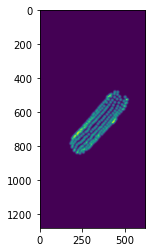

In [20]:
plt.imshow(image)

In [4]:
root_path =  "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn2/corn_seed_counting_train_v2_clean/"
sigma = 5
dataset = "new"
mode = "train"
df_i = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_info.csv" )
df_p = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_positions.csv" )


### Loop over all the images in the dataset
for im in list(df_i["path_img"]):
    ### Get the information
    kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
    ### Produce the maps
    image = generate_label(kernel_positions, shape,sigma)
    ### Save map
    path_map = root_path + f"{dataset}_coco/" +file[:-4]+"_map"+file[-4:]
    plt.imsave(path_map, image)

KeyError: 'path_img'

In [5]:
df_i

,id,file_name,height,width,counts
0,0,train/IMG_20190831_163636.jpg,1280,622,312
1,1,train/IMG_20190831_163641.jpg,3998,2998,324
2,2,train/IMG_20190831_163720.jpg,3998,2998,310
3,3,train/IMG_20190831_163733.jpg,3998,2998,309
4,4,train/IMG_20190831_163800.jpg,3998,2998,318
...,...,...,...,...,...
102,102,train/photo_2019-09-18_17-49-03.jpg,1280,622,244
103,103,train/photo_2019-09-18_17-49-07.jpg,1280,622,240
104,104,train/photo_2019-09-18_17-49-09.jpg,1280,622,228
105,105,train/photo_2019-09-18_17-49-12.jpg,1280,622,223


In [5]:
df_p

,image_id,kernel_x,kernel_y
0,0,1800,3166
1,0,1699,3167
2,0,1877,3138
3,0,1592,3118
4,0,1528,3120
...,...,...,...
29771,106,454,496
29772,106,418,494
29773,106,436,492
29774,106,456,481
